In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from scipy.sparse.csgraph import shortest_path
from scipy.spatial import distance_matrix

In [4]:
rng = np.random.RandomState(42)

In [5]:
# Create swiss roll (classic 2D manifold in 3D)
n_samples = 1500
X, t = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=rng)
print("X shape:", X.shape)

X shape: (1500, 3)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

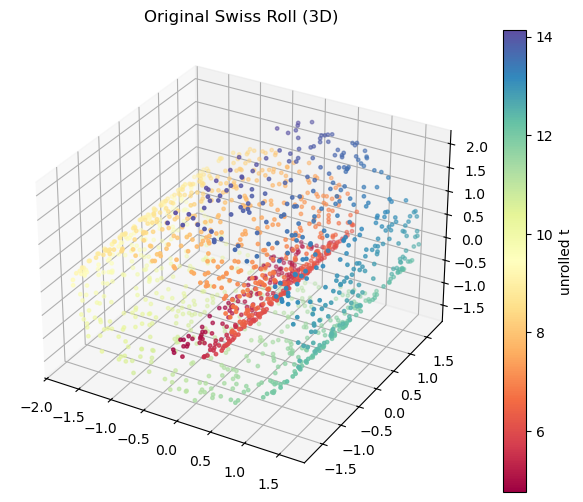

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2], c=t, cmap='Spectral', s=6)
ax.set_title("Original Swiss Roll (3D)")
plt.colorbar(p, label='unrolled t')
plt.show()

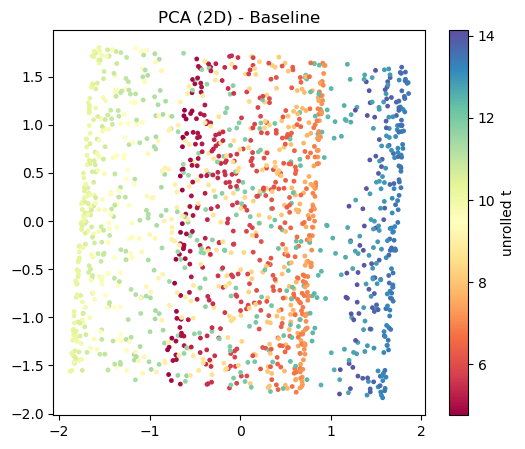

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=t, cmap='Spectral', s=6)
plt.title("PCA (2D) - Baseline")
plt.colorbar(label='unrolled t')
plt.show()

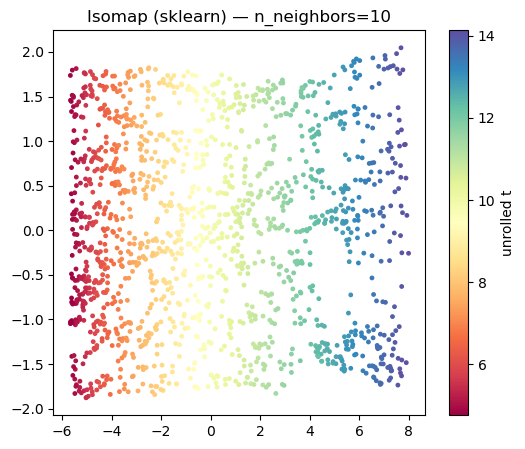

In [ ]:
# sklearn Isomap - quick and easy
n_neighbors = 10   # tune this!
n_components = 2
iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_iso = iso.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_iso[:,0], X_iso[:,1], c=t, cmap='Spectral', s=6)
plt.title(f"Isomap (sklearn) — n_neighbors={n_neighbors}")
plt.colorbar(label='unrolled t')
plt.show()

Graph built. Example row with finite entries: [   0  160  282  465  521  909  963  994 1128 1266]


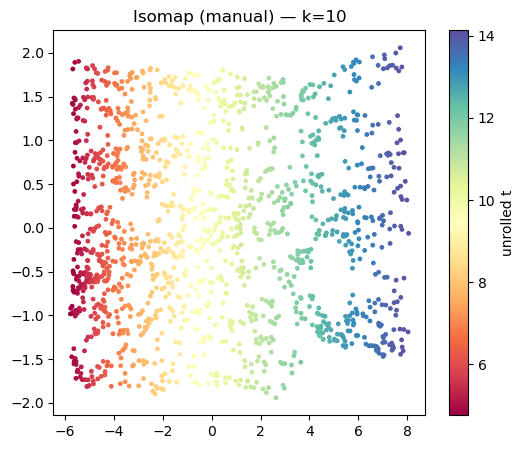

In [10]:
# Manual Isomap implementation (educational)
from sklearn.neighbors import NearestNeighbors

def build_knn_graph(X, k=10, metric='euclidean'):
    n = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(X)
    distances, indices = nbrs.kneighbors(X)
    # Build adjacency matrix as full pairwise with infinities
    graph = np.full((n, n), np.inf)
    # connect neighbors (symmetric)
    for i in range(n):
        for j_idx, dist in zip(indices[i], distances[i]):
            graph[i, j_idx] = dist
            graph[j_idx, i] = dist
    return graph

def classical_mds_from_distances(Dsq, n_components=2):
    # Dsq: squared distance matrix (n x n)
    n = Dsq.shape[0]
    # Double centering
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H.dot(Dsq).dot(H)
    # Eigen-decompose
    eigvals, eigvecs = np.linalg.eigh(B)
    # sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    # keep top components (only positive eigenvalues)
    pos = eigvals > 1e-9
    L = np.diag(np.sqrt(eigvals[pos][:n_components]))
    V = eigvecs[:, pos][:, :n_components]
    Y = V.dot(L)
    return Y, eigvals

# Build k-NN graph
k = 10
G = build_knn_graph(X_scaled, k=k, metric='euclidean')
print("Graph built. Example row with finite entries:", np.where(np.isfinite(G[0]))[0][:10])

# Compute all-pairs shortest path distances (geodesic approx) — uses Dijkstra/Floyd-Warshall depending on input
D = shortest_path(G, method='D', directed=False)   # D is n x n matrix of geodesic distances
# If graph is disconnected, some distances will be inf -> check
if np.isinf(D).any():
    print("WARNING: Graph not fully connected. Increase k or use radius to connect graph.")

# Square them and run classical MDS
Dsq = D**2
Y_iso_manual, eigvals = classical_mds_from_distances(Dsq, n_components=2)

plt.figure(figsize=(6,5))
plt.scatter(Y_iso_manual[:,0], Y_iso_manual[:,1], c=t, cmap='Spectral', s=6)
plt.title(f"Isomap (manual) — k={k}")
plt.colorbar(label='unrolled t')
plt.show()


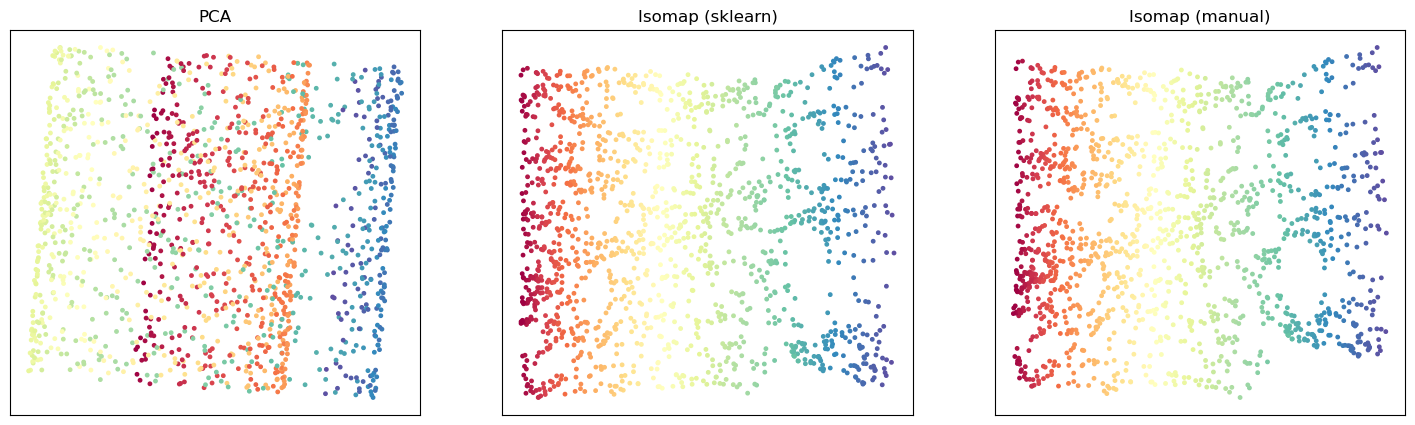

In [11]:
#  side-by-side comparison
fig, axes = plt.subplots(1,3,figsize=(18,5))
axes[0].scatter(X_pca2[:,0], X_pca2[:,1], c=t, cmap='Spectral', s=6)
axes[0].set_title("PCA")
axes[1].scatter(X_iso[:,0], X_iso[:,1], c=t, cmap='Spectral', s=6)
axes[1].set_title("Isomap (sklearn)")
axes[2].scatter(Y_iso_manual[:,0], Y_iso_manual[:,1], c=t, cmap='Spectral', s=6)
axes[2].set_title("Isomap (manual)")
for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])
plt.show()


In [12]:
# Cell 7: Connectivity check for different k values
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

def connectivity_for_k(X, k_values):
    out = {}
    for k in k_values:
        nbrs = NearestNeighbors(n_neighbors=k).fit(X)
        _, idx = nbrs.kneighbors(X)
        n = X.shape[0]
        rows = np.repeat(np.arange(n), k)
        cols = idx.ravel()
        data = np.ones(len(rows))
        A = csr_matrix((data, (rows, cols)), shape=(n, n))
        # make symmetric
        A = (A + A.T) > 0
        n_components, labels = connected_components(A)
        out[k] = n_components
    return out

k_vals = [5, 7, 10, 15, 20]
print("Connected components by k:", connectivity_for_k(X_scaled, k_vals))


Connected components by k: {5: 3, 7: 1, 10: 1, 15: 1, 20: 1}
